<a href="https://colab.research.google.com/github/AloraTab/aat2000/blob/main/dissy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# %pip install pandas==1.5.3
# %pip install keras-lookahead
# %pip install keras-rectified-adam
# %pip install tensorflow-addons==0.19.0
# %pip install keras==2.11.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 33.2 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for keras-lookahead: filename=keras_lookahead-0.9.0-py3-none-any.whl size=6402 sha256=85c9ac48cd841d0aef8170dacdfb1d298b7ef5f1fbf535c8cb922088a06c1f4f
  Stored in directory: /root/.cache/pip/wheels/0f/c2/3f/81c19ff3ba9f985dbed18cfc261440fdcea3a6fb0c6739bb06
Successfully built keras-lookahead
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for keras-rectified-adam: filename=keras_rectified_adam-0.20.0-

In [2]:
from tensorflow import keras
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Attention
from keras_radam import RAdam
from keras_lookahead import Lookahead
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.optimizers.schedules import ExponentialDecay


import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
PATH = '/content/gdrive/MyDrive/Colab Notebooks/Dataset'
fileName = 'csi-dataset-20-4-5.pkl'
fullPath = os.path.join(PATH, fileName)
print(fullPath)

/content/gdrive/MyDrive/Colab Notebooks/Dataset/csi-dataset-20-4-5.pkl


In [5]:
df = pd.read_pickle(fullPath)

In [20]:
df = df.sample(frac=1)
Y = df['Label'].values
X = df['Sample'].values
X = [[np.asarray(sample) for sample in i] for i in X]
X = np.asarray(X).astype('float32')

In [21]:
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
vectorized_y = np_utils.to_categorical(encoded_Y)

In [22]:
classes = encoder.classes_
print(classes)

['I1' 'I13' 'I2' 'I3' 'I4']


In [49]:
X_train, X_test, Y_train, Y_test = train_test_split(X,vectorized_y, test_size=0.3, random_state=40)

In [57]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],X_train.shape[2],1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],X_test.shape[2],1))

X_train = tf.convert_to_tensor(X_train)
Y_train = tf.convert_to_tensor(Y_train)

In [25]:
# Mish Activation
def mish(inputs):
    x = tf.nn.softplus(inputs)
    x = tf.nn.tanh(x)
    x = tf.multiply(x,inputs)
    return x

In [26]:
print(tf.__version__)
import sys
print(sys.version)

2.11.0
3.9.16 (main, Dec  7 2022, 01:11:51) 
[GCC 9.4.0]


In [27]:
# Ranger Optimizer
# www.kaggle.com/code/yazanmajzob/ranger-optimizeranvas.com

import tensorflow_addons as tfa

def Ranger(sync_period=6,
           slow_step_size=0.5,
           learning_rate=0.001,
           beta_1=0.9,
           beta_2=0.999,
           epsilon=1e-7,
           weight_decay=0.,
           amsgrad=False,
           sma_threshold=5.0,
           total_steps=0,
           warmup_proportion=0.1,
           min_lr=0.,
           name="Ranger"):
    inner = tfa.optimizers.RectifiedAdam(learning_rate, beta_1, beta_2, epsilon, weight_decay, amsgrad, sma_threshold, total_steps, warmup_proportion, min_lr, name)
    optim = tfa.optimizers.Lookahead(inner, sync_period, slow_step_size, name)
    return optim

In [28]:
def csiTime_block(input_layer):
    layer_1 = Conv2D(10, (1,1), padding='same', activation='relu')(input_layer)
    layer_1 = Conv2D(10, (10,10), padding='same', activation='relu')(layer_1)

    layer_2 = Conv2D(10, (1,1), padding='same', activation='relu')(input_layer)
    layer_2 = Conv2D(10, (20,20), padding='same', activation='relu')(layer_2)

    layer_3 = Conv2D(10, (1,1), padding='same')(input_layer)
    layer_3 = Conv2D(10, (40,40), padding='same', activation='relu')(layer_3)

    mid_1 = keras.layers.concatenate([layer_1, layer_2, layer_3], axis = 3)

    layer_4 = keras.layers.BatchNormalization()(mid_1)
    
    
    layer_4 = keras.layers.MaxPooling2D()(layer_4)
    # layer_4 = SeqSelfAttention(attention_activation='sigmoid')([layer_4, layer_4])
    attn = keras.layers.Attention()([layer_4, layer_4])
    # flatten = keras.layers.Flatten()(attn)
    output_layer = keras.layers.Dense(8, activation='relu')(attn)
    
    return output_layer

In [29]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape, dtype='float32')

    fir = csiTime_block(input_layer)
    sec = csiTime_block(fir)
    # thi = csiTime_block(sec)
    # fou = csiTime_block(thi)
    # fif = csiTime_block(fou)
    # six = csiTime_block(fif)

    gap = keras.layers.GlobalAveragePooling2D()(sec)
    # layer_4 = keras.layers.Flatten()(layer_4)
    output_layer = keras.layers.Dense(5, activation=mish)(gap) #Need to change to num of classes
    
    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=X_train.shape[1:])
# keras.utils.plot_model(model, show_shapes=True)

In [30]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 180, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_12 (Conv2D)             (None, 256, 180, 10  20          ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_14 (Conv2D)             (None, 256, 180, 10  20          ['input_2[0][0]']                
                                )                                                           

In [42]:
epochs = 150
batch_size = 32

lr_schedule = ExponentialDecay(
    initial_learning_rate=0.1,
    decay_steps=100, decay_rate=0.96,
    staircase=True)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "sa-mish-adam-150.h5", save_best_only=True, monitor="val_loss"
    ),
    # keras.callbacks.ReduceLROnPlateau(
    #     monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    # ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=30, verbose=1),
]
model.compile(
    optimizer=Ranger(learning_rate = lr_schedule),
    loss="categorical_crossentropy",
    metrics=["categorical_accuracy"],
)
history = model.fit(
    X_train,
    Y_train,
    # steps_per_epoch = int(trainX_size/batch_size),
    # validation_steps = int(trainY_size/batch_size),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
    
)

Epoch 1/150
83/83 [==============================] - 180s 2s/step - loss: 10.7008 - categorical_accuracy: 0.2047 - val_loss: 10.1376 - val_categorical_accuracy: 0.2112
Epoch 2/150
83/83 [==============================] - 172s 2s/step - loss: 10.7434 - categorical_accuracy: 0.2100 - val_loss: 10.0890 - val_categorical_accuracy: 0.2097
Epoch 3/150
83/83 [==============================] - 172s 2s/step - loss: 10.7495 - categorical_accuracy: 0.2077 - val_loss: 10.1133 - val_categorical_accuracy: 0.2097
Epoch 4/150
83/83 [==============================] - 172s 2s/step - loss: 10.7373 - categorical_accuracy: 0.2122 - val_loss: 10.0890 - val_categorical_accuracy: 0.2097
Epoch 5/150
83/83 [==============================] - 171s 2s/step - loss: 10.7190 - categorical_accuracy: 0.2103 - val_loss: 10.0890 - val_categorical_accuracy: 0.2097
Epoch 6/150
83/83 [==============================] - 172s 2s/step - loss: 10.7190 - categorical_accuracy: 0.2111 - val_loss: 10.0890 - val_categorical_accuracy:

In [52]:
X_test.shape

(1420, 256, 180)

In [51]:
Y_test.shape

(1420, 5)

In [58]:
# model = keras.models.load_model("sa-mish-adam-150.h5")

test_loss, test_acc = model.evaluate(X_test[:,:,:], Y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

45/45 [==============================] - 27s 606ms/step - loss: 0.9421 - categorical_accuracy: 0.5549
Test accuracy 0.5549295544624329
Test loss 0.9421429634094238


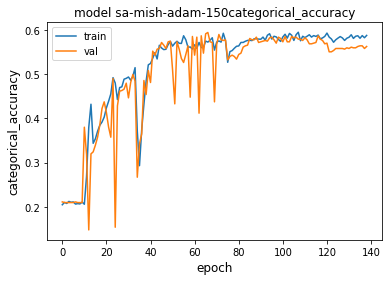

In [44]:
metric = "categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model sa-mish-adam-150" + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [59]:
#Confusion Matrix and Classification Report

y_pred=model.predict(X_test) 
y_pred=np.argmax(y_pred, axis=1)
Y_test=np.argmax(Y_test, axis=1)
cm = confusion_matrix(Y_test, y_pred)
print(cm)

print('Classification Report')
print(classification_report(Y_test, y_pred, target_names=classes))

45/45 [==============================] - 28s 627ms/step
[[ 28  15 155  40   0]
 [  0 429   5  29   0]
 [ 41  28 138  11   0]
 [  3  43   4 190   5]
 [  2  86   0 165   3]]
Classification Report
              precision    recall  f1-score   support

          I1       0.38      0.12      0.18       238
         I13       0.71      0.93      0.81       463
          I2       0.46      0.63      0.53       218
          I3       0.44      0.78      0.56       245
          I4       0.38      0.01      0.02       256

    accuracy                           0.55      1420
   macro avg       0.47      0.49      0.42      1420
weighted avg       0.51      0.55      0.48      1420

